# **TWEETS CLASSIFICATION MODEL**
In this Problem Set, we have to build a Text Classifier which classifies the Twitter Messages regarding Covid Situation into 5 categories: Extremely Negative (0), Negative (1),
Neutral (2), Positive (3), Extremely Positive (4). 


In [1]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**DATA EXPLORATION**

In [2]:
#Uploading the files to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Loading the Necessary Files
tweet_data=pd.read_csv('/content/drive/MyDrive/A5/ps5_tweets_text.csv')
label_data=pd.read_csv('/content/drive/MyDrive/A5/ps5_tweets_labels.csv')
nlabel_data=pd.read_csv('/content/drive/MyDrive/A5/ps5_tweets_labels_as_numbers.csv')
kaggle_data=pd.read_csv('/content/drive/MyDrive/A5/ps5_tweets_text_for_the_kaggle_competition.csv')

In [4]:
#Shape of the Tweet Dataset
print("Shape of the Tweet Dataset=",tweet_data.shape)
print("Shape of the Label Dataset=",label_data.shape)
print("Shape of the Numerical Label Dataset=",nlabel_data.shape)
print("Shape of the Kaggle Dataset=",kaggle_data.shape)

Shape of the Tweet Dataset= (37041, 2)
Shape of the Label Dataset= (37041, 2)
Shape of the Numerical Label Dataset= (37041, 2)
Shape of the Kaggle Dataset= (3798, 2)


In [5]:
#Twitter Data Display
tweet_data.head()

,Id,Tweet
0,0,https://t.co/UpjxfOgQs8\r\r\n\r\r\nGaisss! Ple...
1,1,@mygovindia Today just after a week of lockdow...
2,2,Tuskys partners with Amref to provide on groun...
3,3,@chrissyteigen are u doing ur own grocery shop...
4,4,UK Critical Care Nurse Cries at Empty SuperMar...


In [6]:
#Twitter Data Labels Display
label_data.head()

,Id,Sentiment
0,0,Extremely Positive
1,1,Negative
2,2,Neutral
3,3,Negative
4,4,Extremely Negative


In [7]:
#Numerical Twitter Data Labels Display
nlabel_data.head()

,Id,Label
0,0,4
1,1,1
2,2,2
3,3,1
4,4,0


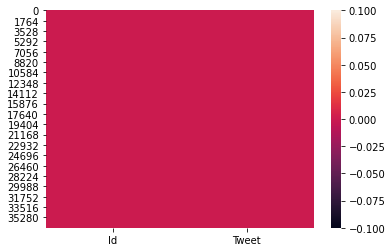

In [8]:
#Checking for Null Values one by one for all files
import seaborn as sns
sns.heatmap(tweet_data.isnull())

In [9]:
#Dropping the Duplicate Values if Any
tweet_data.drop_duplicates(inplace= True)
kaggle_data.drop_duplicates(inplace=True)

In [10]:
#Shape of File After Dropping Duplicates
print(" Shape of File after dropping duplicates: ",tweet_data.shape)

 Shape of File after dropping duplicates:  (37041, 2)


**EXPLORATORY DATA ANALYSIS**

In [11]:
#Merging 2 Labels files for EDA
EDA = pd.merge(label_data, nlabel_data, 
                   on='Id', 
                   how='left')

In [12]:
EDA

,Id,Sentiment,Label
0,0,Extremely Positive,4
1,1,Negative,1
2,2,Neutral,2
3,3,Negative,1
4,4,Extremely Negative,0
...,...,...,...
37036,37036,Negative,1
37037,37037,Negative,1
37038,37038,Extremely Negative,0
37039,37039,Neutral,2


In [13]:
#Class Distribution
class_df = EDA.groupby('Sentiment').count()['Label'].reset_index().sort_values(by='Label',ascending=False)
class_df.style.background_gradient(cmap='PiYG')

,Sentiment,Label
4,Positive,10282
2,Negative,8930
3,Neutral,6930
1,Extremely Positive,5953
0,Extremely Negative,4946


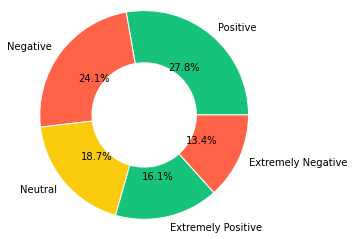

In [14]:
#Pie Chart
percent_class=class_df.Label
labels= class_df.Sentiment

colors = ['#17C37B','#FF6347','#FACA0C']
my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


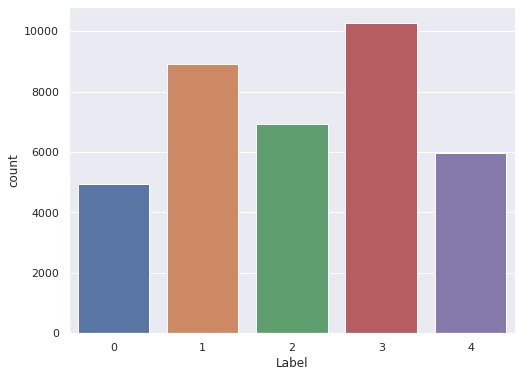

In [15]:
#Visualization of Sentiment Classes
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(nlabel_data['Label'])

# **DATA PREPROCESSING**
Performing Basic Cleaning of the Statement in the Tweets.

In [16]:
#Importing Necessary Libraries for Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


**STOPWORDS**

In [17]:
#Downloading Stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
#Load English Stop Words
stopword = stopwords.words('english')
print("Stopwords:",stopword)

Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so'

Creating the Funtion to Clean the Twitter Message like Removing URL, Removing Mentions, Hashtags, Digits, HTML Tags and Removing the Connecting words included in 'English'Stop words.

In [19]:
#Tweet Clean Function
def tweet_clean(twee):
    #Remove URL
    twee = re.sub(r'https?://\S+|www\.\S+', " ", twee)

    #Remove Mentions
    twee = re.sub(r'@\w+',' ',twee)

    #Remove Punctuation
    twee= re.sub(r'[^\w\s\d]',' ',twee)

    #Remove Digits
    twee = re.sub(r'\d+', ' ', twee)

    #Remove HTML tags
    twee = re.sub('r<.*?>',' ', twee)

    #Remove Hastags
    twee = re.sub(r'#\w+', ' ', twee)

    #Remove Stop Words 
    twee = twee.split()
    #twee = " ".join(twee)
    
    twee = " ".join([word for word in twee if not word in stopword])

    return twee

In [20]:
#Applying Tweet Clean Function to Both Files
tweet_data['Tweet'] = tweet_data['Tweet'].astype(str).apply(lambda x: tweet_clean(x))
kaggle_data['Tweet'] = kaggle_data['Tweet'].astype(str).apply(lambda x: tweet_clean(x))

In [21]:
#Updated Sentiment Data
tweet_data["Tweet"]

0        Gaisss Please read please limit go outside ple...
1        Today week lockdown lot confectionary stores r...
2        Tuskys partners Amref provide ground health ed...
3        u ur grocery shopping like regular person u st...
4        UK Critical Care Nurse Cries Empty SuperMarket...
                               ...                        
37036    Minnesota classifies grocery store workers eme...
37037    US Senator asked information leveragedloans pr...
37038    Just commented Poll Are online shopping normal...
37039    My wife got laid yesterday small retail store ...
37040    Humanity doomed coronavirus coronacrisis toile...
Name: Tweet, Length: 37041, dtype: object

In [22]:
#Converting Tweets to String for Stemming and Word Net Lemmatizer 
tweets = tweet_data["Tweet"]
print(tweets)

0        Gaisss Please read please limit go outside ple...
1        Today week lockdown lot confectionary stores r...
2        Tuskys partners Amref provide ground health ed...
3        u ur grocery shopping like regular person u st...
4        UK Critical Care Nurse Cries Empty SuperMarket...
                               ...                        
37036    Minnesota classifies grocery store workers eme...
37037    US Senator asked information leveragedloans pr...
37038    Just commented Poll Are online shopping normal...
37039    My wife got laid yesterday small retail store ...
37040    Humanity doomed coronavirus coronacrisis toile...
Name: Tweet, Length: 37041, dtype: object


**PORTER STEMMER** 
The Porter stemming algorithm (or 'Porter stemmer') is a process for removing the commoner morphological and inflexional endings from words in English. 


In [ ]:
#Porter Stemmer
stemmer=nltk.stem.PorterStemmer()
" ".join(stemmer.stem(token) for token in tweets)

In [24]:
tweets[0]

'Gaisss Please read please limit go outside please please always wash hands always use hand sanitizer And please get ready stock food'

**WORDNET LEMMATIZER** 
Lemmatize using WordNet's built-in morphy function. Returns the input word unchanged if it cannot be found in WordNet.

In [25]:
#Downloading Wordnet
#nltk.download('wordnet')

In [26]:
#Word Net Lemmatizer
#stemmer=nltk.stem.WordNetLemmatizer()
#" ".join(stemmer.lemmatize(token) for token in tweets)

In [27]:
tweets[5]

'Makes heart ache elderly make disease either people want yo starve force every day expose bulk buy selfish b ds stopthepeak stayhome'

**TOKEN INITIALIZATION**

In [28]:
#Splitting the Data set into Dependent and Independent Features
X=tweets
y=nlabel_data['Label']

In [29]:
#Maximum Length of Sequence
max_len = np.max(X.apply(lambda x :len(x)))
print("Maximum length of sequence:",max_len)

Maximum length of sequence: 286


In [30]:
#Initializing Tokens
tokenizer = Tokenizer()

#Text to Sequence
tokenizer.fit_on_texts(X)
vocab_length = len(tokenizer.word_index)+1
print("Length of Word Index:",vocab_length)
X = tokenizer.texts_to_sequences(X)

#Post Padding
X = pad_sequences(X,maxlen=max_len, padding='post')

Length of Word Index: 40786


In [31]:
#Array of Tweet Data
X

array([[19278,    40,   128, ...,     0,     0,     0],
       [   48,    83,    65, ...,     0,     0,     0],
       [14008,  2042, 19281, ...,     0,     0,     0],
       ...,
       [  154, 10652,  2695, ...,     0,     0,     0],
       [  104,  1072,   139, ...,     0,     0,     0],
       [ 1367,  9918,     2, ...,     0,     0,     0]], dtype=int32)

In [32]:
#Shape of X
X.shape

(37041, 286)

In [33]:
#Transforming a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

# **MODEL SELECTION**
Implementing 2 NLP Models such as RNN Model with GRU and LSTM Architecture

In [34]:
#Performing Test-Train-Valid Split in the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [35]:
#Shape of the Training and Testing Data
X_train.shape, X_test.shape,  y_train.shape, y_test.shape #,y_val.shape,X_val.shape

((29632, 286), (3705, 286), (29632, 5), (3705, 5))

In [36]:
#Dimension of Embedding
embedding_dim = 32

**RECURRENT NEURAL NET: GRU LAYER**

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])
#Model Summary of GRU Layer Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 286, 32)           1305152   
_________________________________________________________________
bidirectional (Bidirectional (None, 286, 512)          445440    
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,783,749
Trainable params: 1,783,749
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Model Compilation 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
               metrics=["accuracy"
                       #tf.metrics.AUC(multi_label=True,name='auc_multi',label_weights=[0.1,0.4,0.6]),
               ])

In [39]:
#Fitting the Model
gru=model.fit(X_train, y_train,
               callbacks=[EarlyStopping(monitor='val_loss', mode='min' , verbose =1, patience = 2)],
          validation_data=(X_test,y_test),
          epochs=10)

Epoch 1/10
926/926 [==============================] - 43s 41ms/step - loss: 1.5534 - accuracy: 0.2880 - val_loss: 1.1231 - val_accuracy: 0.5460
Epoch 2/10
926/926 [==============================] - 37s 40ms/step - loss: 0.9283 - accuracy: 0.6372 - val_loss: 0.7796 - val_accuracy: 0.7282
Epoch 3/10
926/926 [==============================] - 37s 40ms/step - loss: 0.5623 - accuracy: 0.8046 - val_loss: 0.7144 - val_accuracy: 0.7501
Epoch 4/10
926/926 [==============================] - 37s 40ms/step - loss: 0.3852 - accuracy: 0.8746 - val_loss: 0.7483 - val_accuracy: 0.7490
Epoch 5/10
926/926 [==============================] - 37s 40ms/step - loss: 0.2879 - accuracy: 0.9092 - val_loss: 0.8441 - val_accuracy: 0.7493
Epoch 00005: early stopping


**RECURRENT NEURAL NETWORK : LSTM LAYER**

In [40]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
#Model Summary of LSTM Layer Architecture
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 286, 32)           1305152   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 286, 512)          591872    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 2,570,181
Trainable params: 2,570,181
Non-trainable params: 0
_________________________________________________________________


In [41]:

#Model Compilation 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model2.compile(optimizer=opt,
               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
               metrics=["accuracy"
                       #tf.metrics.AUC(multi_label=True,name='auc_multi',label_weights=[0.1,0.4,0.6]),
               ])

In [42]:
#Fitting the Model
lstm=model2.fit(X_train, y_train,
               callbacks=[EarlyStopping(monitor='val_loss', mode='min' , verbose =1, patience = 2)],
          validation_data=(X_test,y_test),
          epochs=10)

Epoch 1/10
926/926 [==============================] - 74s 75ms/step - loss: 1.3371 - accuracy: 0.4113 - val_loss: 0.7912 - val_accuracy: 0.7112
Epoch 2/10
926/926 [==============================] - 68s 74ms/step - loss: 0.6187 - accuracy: 0.7789 - val_loss: 0.7096 - val_accuracy: 0.7503
Epoch 3/10
926/926 [==============================] - 68s 74ms/step - loss: 0.4332 - accuracy: 0.8566 - val_loss: 0.7535 - val_accuracy: 0.7506
Epoch 4/10
926/926 [==============================] - 68s 74ms/step - loss: 0.3152 - accuracy: 0.8985 - val_loss: 0.7771 - val_accuracy: 0.7476
Epoch 00004: early stopping


# **MODEL EVALUATION**
Calculating Validation Loss & Accuracy, F1 Macro, Confusion Matrix and Classification Report one by one for each model


**Training-Validation Loss & Accuracy Graphs**

In [43]:
#Validation Loss and Validation Accuracy
acc = gru.history['accuracy']
val_acc = gru.history['val_accuracy']

loss = gru.history['loss']
val_loss = gru.history['val_loss']

In [44]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")


Accuracy on training data is:- 90.54062962532043 %
Loss 29.87000048160553
Accuracy on validation data is:- 74.9257743358612 %
Loss 84.40727591514587


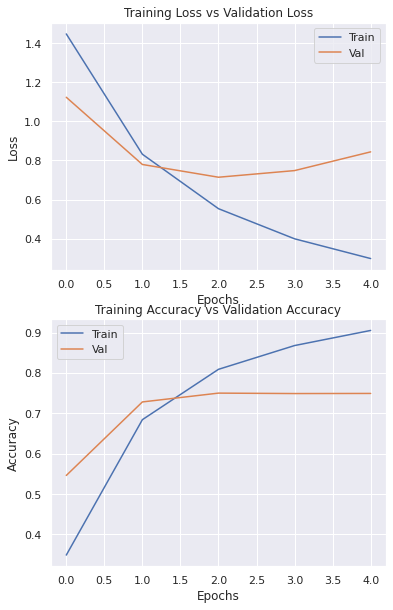

In [45]:
#Plotting Traning and Validation Loss,Accuracy of Models
#Loss
fig, axs = plt.subplots(2, 1, figsize=(6,10))
axs[0].plot(gru.history['loss'])
axs[0].plot(gru.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

#Accuracy
axs[1].plot(gru.history['accuracy'])
axs[1].plot(gru.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

**Prediction on Test Data**

In [46]:
#Making Prediction for each model
pred = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [47]:
#Predicted Output
pred

array([3, 1, 3, ..., 2, 3, 1])

In [48]:
#Converting Matrix Labels data to Single Digit
slabels=np.argmax(y_test, axis=1)
slabels[13]

0

**F1 Macro**

In [49]:
# Calculating F1-score for Model
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score
print("F1-score of RNN GRU Model:",f1_score(slabels,pred, average='macro'))

F1-score of RNN GRU Model: 0.7563941729075973


**Confusion Matrix**

In [50]:
#Confusion Matrix for GRU Layer Model:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(slabels, pred)
cm

array([[334, 137,   2,  17,   1],
       [ 55, 652,  49, 107,   4],
       [  4,  84, 561,  64,   4],
       [  9, 106,  59, 740,  98],
       [  1,  10,   4, 114, 489]])

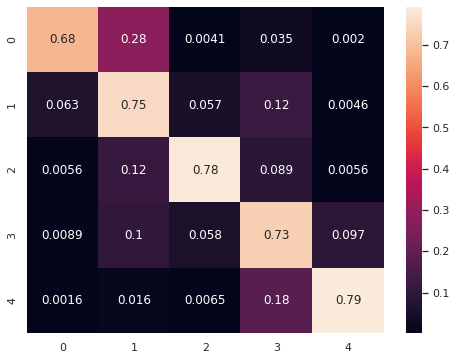

In [51]:
#Visualization of Confusion Matrix
cm2 = confusion_matrix(slabels, pred,normalize="true")
sns.heatmap(cm2,annot=True)

In [52]:
#Function Calculate Accuracy
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
print("Accuracy of Model:",accuracy(cm))

Accuracy of Model: 0.7492577597840756


**AUC Score**

In [53]:
# Calculating AUC Score for GRU RNN Model
print("AUC Score of GRU RNN Model:",roc_auc_score(slabels,model.predict_proba(X_test),multi_class='ovr'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC Score of GRU RNN Model: 0.9319780463172505


**Classification Report**

In [54]:
#Classification Report of Model
print(classification_report(np.argmax(y_test,1),pred))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       491
           1       0.66      0.75      0.70       867
           2       0.83      0.78      0.81       717
           3       0.71      0.73      0.72      1012
           4       0.82      0.79      0.81       618

    accuracy                           0.75      3705
   macro avg       0.77      0.75      0.76      3705
weighted avg       0.76      0.75      0.75      3705



**Kaggle Data**

In [55]:
kaggle=kaggle_data["Tweet"]
print(kaggle)

0       TRENDING New Yorkers encounter empty supermark...
1       When I find hand sanitizer Fred Meyer I turned...
2                     Find protect loved ones coronavirus
3       Panic buying hits NewYork City anxious shopper...
4       toiletpaper dunnypaper coronavirus coronavirus...
                              ...                        
3793    Meanwhile In A Supermarket Israel People dance...
3794    Did panic buy lot non perishable items ECHO ne...
3795    Asst Prof Economics talking recent research co...
3796    Gov need somethings instead biar je rakyat ass...
3797    I members committed safety employees end users...
Name: Tweet, Length: 3798, dtype: object


In [56]:
#Maximum Length of Sequence
max_len1 = np.max(kaggle.apply(lambda x :len(x)))
print("Maximum length of sequence:",max_len1)

Maximum length of sequence: 265


In [57]:
 #Text to Sequence
kaggle = tokenizer.texts_to_sequences(kaggle)

#Post Padding
kaggle = pad_sequences(kaggle,maxlen=max_len1, padding='post')

In [58]:
#Predicting the Classification of Kaggle Dataset and converting it into Dataframe
kag_label = model.predict_classes(kaggle)
kag_predict = pd.DataFrame()
kag_predict["Predicted"]=kag_label

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [59]:
kag_predict

,Predicted
0,1
1,3
2,4
3,1
4,2
...,...
3793,3
3794,1
3795,2
3796,0


In [60]:
#Converting to CSV Format
#kag_predict.to_csv("try9.csv")

In [61]:
#from google.colab import files
#files.download("try9.csv")

I have Implemented the Basic Models like Multinomial Naive Bayes and Linear SVM in another notebook due to Runtime Crash issue in Colab.